This week's assignment consists of two parts. The first part gives you an introduction to unsupervised learning. In particular, we focus on techniques for clustering and dimensionality reduction and how they can be applied to ecommerce data. As you work through the three clustering case studies, you will find yourself generating many intermediate datasets, trying different models, and tuning each model as you go along. There's a lot to keep track of.   

This is where Part 2 comes in. It is in Part 2 that we introduce ideas of **workflow management** and **computational reproducibility**. Workflow management means organising your project directory to manage your analysis' artefacts (visualisations, processed datasets, notebooks and utility functions and experiment results). Ideally, your code for these should be clearly commented with well chosen names. Computational reproducibility means someone else (including future you!) being able to take just the code and data, and reproduce your project, from its results and models to visualisations etc. How one decides to practice workflow management and computational reproducibility can be quite a personal decision. Therefore, we provide guidelines, not rules. The most important is having a system rather than no system at all. 

**note about the week**   
While week 1's assignment was guided, with specific instructions about what code to run, as we move on the assignments will involve less hand-holding. For this week, we include some instructions, but leave the specific implementations up to you. There are also many techniques we cover. Again, while we share some resources, we leave the bulk of the research and background reading up to you to manage for yourself. As a record of how well you have synthesised your readings, this notebook has space for writing a few paragraphs of explanations. We hope you won't be content with a shallow explanation, and that you use this space to apply the [Feynmann technique](https://collegeinfogeek.com/feynman-technique/) as a check of understanding. 

To tie Part 1 and Part 2 of the week together, we are not just asking for one Jupyter Notebook as a final deliverable. Instead, there are four deliverables to the week: 

**1. Part 1 Notebook I and II exercises presented at the end of the week job-interview style**

**2. A script that automates the data cleaning and feature engineering steps you take so your findings are reproducible (see Part 2 Notebook I for more info)**

**3. A repo README.md (see Part 2 Notebook I for more info)**

**4  A record of software package versions and software environment used (see Part 2 Notebook I for more info)**   

**recap of the objectives for the first 6 weeks:**  
We aim to broadly cover a wide range of Machine Learning algorithms so that you can: 
- handle the technical demands of a 100E given some guidance on the right direction to take 
- can handle a technical job interview and get hired 

*materials for unsupervised learning adapted from William Thji* 

# Part I : Unsupervised Learning 
Unsupervised Learning refers to a set of machine learning techniques where no output variables (Y) are given. Only the input variables (X) are available and our job is to find patterns in X. You may read more about it from *pg 485 from Hastie and Tibshirani's Elements of Statistical Learning* available [here](https://web.stanford.edu/~hastie/Papers/ESLII.pdf). 

ESL by Hastie et. al with be the primary reference for this week, although feel free to source for your own books and links. 

## Short introduction to clustering 
Clustering puts datapoints into subsets so that datapoints within a cluster are more closely related to one another compared to datapoints in another cluster. More information is available from page 501 of *Elements of Statistical Learning*. 

Some quick points: 
- Clustering is extremely useful to many fields: 
    - Customer segmentation for personalised product recommendations
    - Topic identification to relieve the need to manually vet documents 
    - Image or geo-spatial segmentation to optimised supply and demand (Gojek does this) 
    - and maybe most importantly, getting a sense of the data before starting to model it. 

- Some examples of clustering algorithms: 
    - KMeans
    - Gaussian Mixture Models for drawing soft clustering boundaries instead of hard ones 
    - Hierarchical clustering
    - DBScan for density-based clustering for anomaly detection 
    - Co-clustering
    - Biclustering for analysing genes

## Deliverable 1: Complete the Clustering Case Study: Using PCA and clustering to uncover customer segments 
Context: The dataset we will be working with contains ecommerce transactions from a UK-based online retails store. The dataset is available on [Kaggle](https://www.kaggle.com/carrie1/ecommerce-data/home) or the UCI Machine Learning Repository. The dataset is quite small, so we have also included it inside the `data` folder inside this repo as `data/raw/data.csv`. 

From the Kaggle website: 

"This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers."

### Case Study Goal 
Cluster the dataset into meaningful customer segments. This means creating clusters that are statistically robust and that make business sense. 


In [148]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
import pandas as pd 
import seaborn as sns

In [2]:
df = pd.read_csv('data/raw/data.csv', encoding='ISO-8859-1')
df_org = df.copy()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Cleaning data 

Some data types are muddled, there are duplicates, NA values and unreasonable values hiding in the columns 

1. Clean the dataset. You may want to list the steps taken to clean the data and encapsulate the steps inside their own functions so they can be reused. Organise the functions into their own library

Things we can expect from the dataset at first glance:
1. There should be unique StockCode, Description and UnitPrice sets.
2. Each InvoiceNo should only contain 1 customer.

#### Checking for Null Values

Description => damaged , damages, faulty 

- reduces quantity. Stock Code is retrievable

Description missing but StockCode present
Typos in the Description, spaces etc

One way to fill up Description would be to fill in the missing Description Values with their Stock Codes. This is sufficient as we can ignore other descriptions about faulty and damages as we are aggregating the data by customerID eventually. 

Negative quantities seem to be due to discounts, damages or freebies. 

__Discoveries for Description__

Points to correct:
1. Description has 1454 missing values
2. StockCode and Description should refer to the same object. But when applying _value_counts()_, we observe that the numbers to not tally one to one.
3. There are more overall unique values to StockCode compared to Description as well.
4. Replaced missing descriptions with most common description used for stock code.

__Discoveries for CustomerID__

1. CustomerID has 135080 missing values
2. Since we are concerned with doing unsupervised learning on customer IDs and we are unable to fill up invoices with missing invoice IDs

In [3]:
df = df[df['CustomerID'].notna()]

In [4]:
#remove negative prices and negative quantities
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

__All Discoveries__

1. Multiplying quantity and unit price gives us the revenue for the partiular line in the dataset. (if negative quantity, then negative revenue. Unit price is always positive)

### Feature Engineering iteration #1 

Inside the dataset, each row contains information about an ecommerce transation. However, we want to cluster the data by customers, which means each row should instead contain information about a customer. 

1. Reshape the data to follow the format below: 
![alt text](customer.png)

The dataframe should have these columns: `['NoOfInvoices', 'NoOfUniqueItems', 'QuantityPerInvoice', 'TotalQuantity', 'UniqueItemsPerInvoice','UnitPriceMean','UnitPriceStd']` 
2. Save this dataset as an intermediate dataset 

In [5]:
# Adding a spent column
df['Spend'] = df['Quantity'] * df['UnitPrice']

In [98]:
# Aggregating of data and forming columns
grouped = df.groupby('CustomerID')
s_noofinvoices = grouped['InvoiceNo'].agg(lambda x: x.nunique())
s_noofuniqueitems = grouped['StockCode'].agg(lambda x: x.nunique())
#quantity refers to the number of invoice lines
s_totalquantity = grouped['Quantity'].count()
grouped_inv = df.groupby(['CustomerID', 'InvoiceNo'])
s_quantityperinvoice = pd.DataFrame(grouped_inv['Quantity'].agg(np.sum)).reset_index().groupby('CustomerID')['Quantity'].agg(np.mean)
s_spendingperinvoice = pd.DataFrame(grouped_inv['Spend'].agg(np.sum)).reset_index().groupby('CustomerID')['Spend'].agg(np.mean)
s_uniqueitemsperinvoice = pd.DataFrame(grouped_inv['StockCode'].agg(lambda x: x.nunique())).reset_index().groupby('CustomerID')['StockCode'].agg(np.mean)
s_unitpricemean = grouped['UnitPrice'].agg(np.mean)
s_unitpricestd = grouped['UnitPrice'].agg(np.std)

df_cust = pd.DataFrame({'NoOfInvoices':s_noofinvoices, 'NoOfUniqueItems':s_noofuniqueitems, 'QuantityPerInvoice':s_quantityperinvoice, 'SpendingPerInvoice':s_spendingperinvoice, 'TotalQuantity':s_totalquantity, 'UniqueItemsPerInvoice':s_uniqueitemsperinvoice,'UnitPriceMean':s_unitpricemean,'UnitPriceStd':s_unitpricestd})
df_cust = df_cust.reset_index(level='CustomerID')
# converting customer ID from float to str
df_cust['CustomerID'] = df_cust['CustomerID'].astype(int).astype(str)

df_cust['UnitPriceStd'] = df_cust['UnitPriceStd'].fillna(0)

###### Hierarchical clustering iteration #1 [reference pg 520](https://web.stanford.edu/~hastie/Papers/ESLII.pdf)

1. Implement any more preprocessing or visualisation steps you feel are necessary to understand how you might build meaningful clusters from the data. 
2. Apply hierarchical clustering to the dataset. 
2. Experiment with different linkage algorithms. Visualise the resulting trees for average linkage, complete linkage and single linkage side-by-side. Which linkage algorithm works best? 
3. List two ways to improve the clustering and implement at least one. Track the results of the first iteration and second iteration (whether with Excel, TextEdit or within this notebook itself). 
4. Describe the clusters you selected and evaluate whether or not they form meaningful segments. 

In [7]:
df_cust['UnitPriceStd'] = df_cust['UnitPriceStd'].fillna(0)

In [14]:
import scipy
#from scipy.cluster.hierarchy import dendogram, linkage
#from scipy.cluster.hierarchy import fcluster
#from scipy.cluster.hierarchy import cophenet
#from scipy.cluster.hierarchy import dist

from sklearn.preprocessing import StandardScaler

from pylab import rcParams
import seaborn as sb
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering

In [15]:
X = np.array(df_cust.iloc[:,1:])
scaler = StandardScaler()
X = scaler.fit_transform(X)

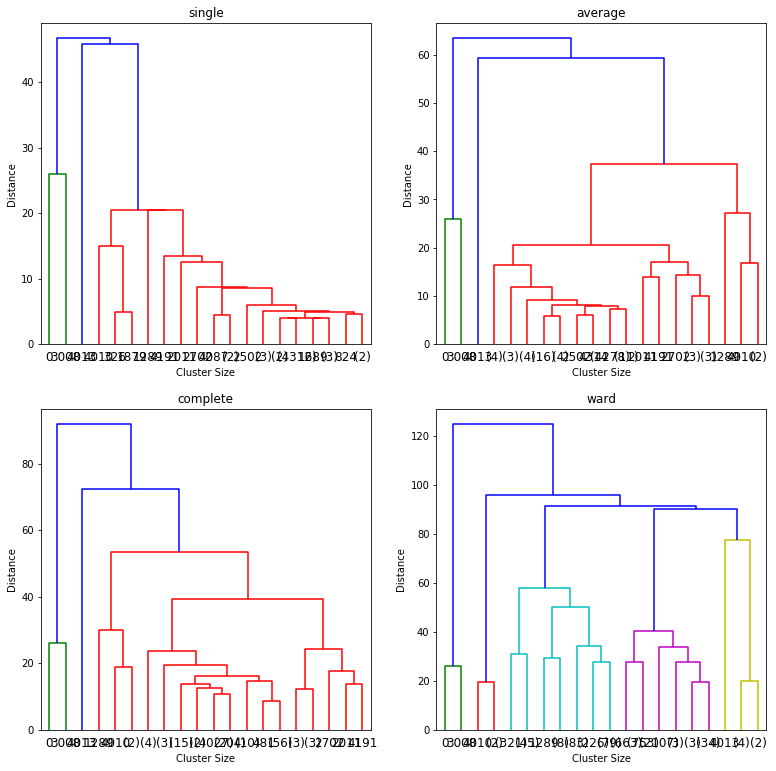

In [16]:
#generating linkage

linkages = ['single', 'average', 'complete', 'ward']
plt.figure(figsize=(13, 13)) 

for idx,i in enumerate(linkages):
    Z = linkage(X, i)
    plt.subplot(2,2,idx+1)
    dend = dendrogram(Z, truncate_mode='lastp', p = 20)
    plt.title(i)  
    plt.xlabel('Cluster Size')
    plt.ylabel('Distance')

plt.show()

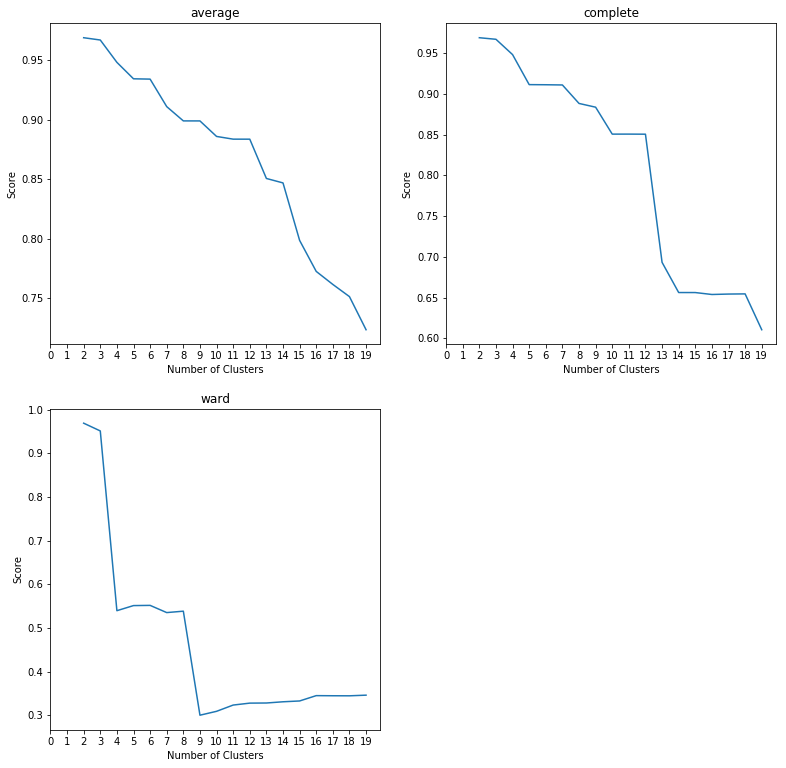

__Discussion__
- Scoring methods for clustering to quantify fit can be generalized into two categories. Internal and External metrics.
- Silhouette scoring is a method is an internal scoring metric that evaluates the average silhouette cofficients of each point determined by $$ (b - a) / max(a, b) $$ where b is the smallest average distance of the point and points in any other one cluster, and a is the average distance between the point and other points in the same cluster. A value closer to 1 is desired as it indicates maximum separability w.r.t. other clusters and maximum similarity with its cluster.

- Single linkage finds the minimum distance between 2 clusters, Complete linkage finds the maximum distance. Average finds the average distance of points between 2 classes. Ward's score calculates the decrease in MSE from the centre of the cluster using the formula $$ \frac{n_A\cdot n_B}{n_A+n_B} ||\vec m_A-\vec m_B||^2 $$

- Plotting the silhouette scores for single, average and complete, we can observe that the 'elbow' for these algorithms is at 3 clusters.
- From the dendogram, it seems like single, average and complete linkages give 3 clusters as ideal, but ward gives 6 clusters as the ideal.

- From the dendogram, there seems to be 5-6 main consumer clusters.

Methods of improving the clustering: 
1. Standardize the features. This is useful to ensure all features have equal weightage.
2. Removal of outlier data. Outlier data may take up a single cluster. This can be identified via the dendogram.
3. Removal of data features that may not be useful in the final interpretation of clusters so they will not influence the clustering algorithm. (Remove total quantity?)
4. Extracting key eigenvectors/ feature combinations from the feature space to streamline clustering. (for large feature spaces)
5. Dropping of negative quantity values and only preserving the positive ones might not result in a population representative. This is due to some dropped items affecting how the net purchases of customers. More data cleaning can be conducted to account for this.

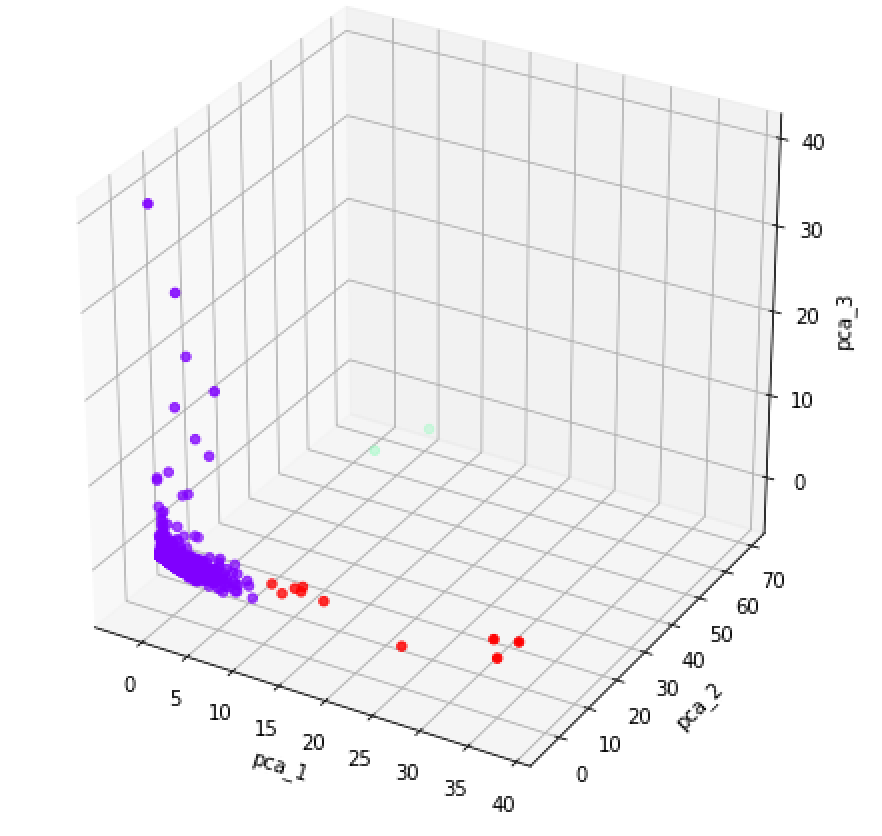

The clusters only contain 4326, 10 and 2 members when n=3 and ward linkage is used.

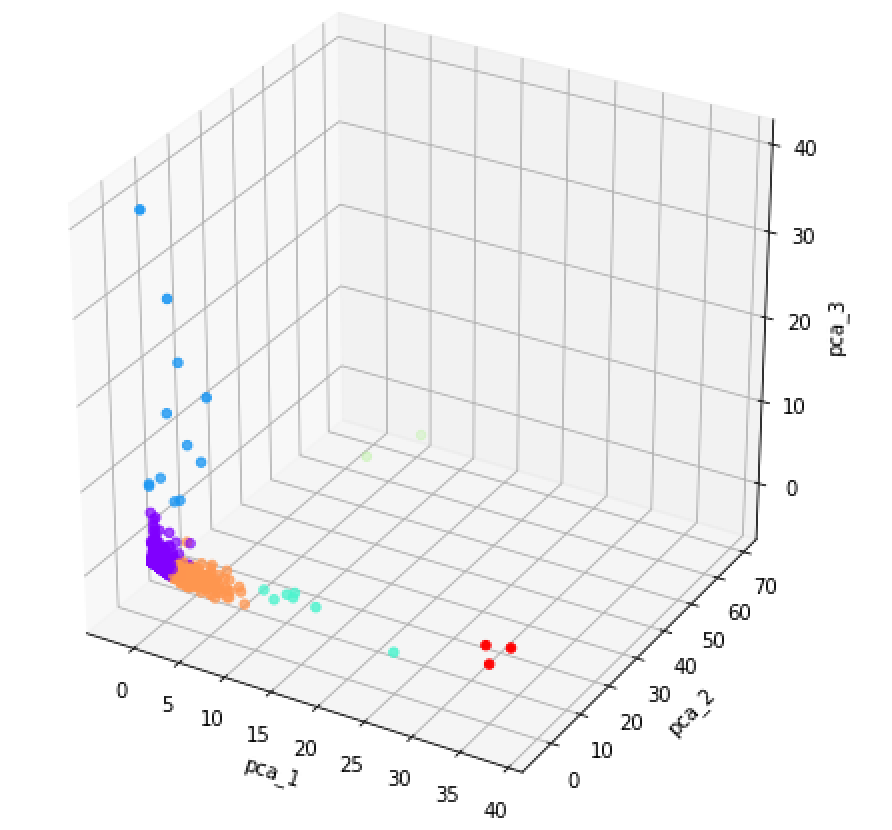

When n is increased to 6, we observe better and more even cluster separation. The original large cluster is split in 3, but there still remains the 2 outlier data points that are in the same cluster.

### K-means and GMM Clustering iteration #1 [reference pg 509](https://web.stanford.edu/~hastie/Papers/ESLII.pdf)
Apart from hierarchical clustering, we can also apply KMeans and Gaussian Mixture Models (GMM) on the data

1. Implement K-means clustering on the data, experimenting with different values of k 
2. Implement a Gaussian Mixture Model on the data, experimenting with different values for the number of components.  
3. Visualise how well K-means and GMMs succeed at separating subgroups in the data
4. List two ways to improve the clustering and implement at least one. 
5. Describe the clusters and evaluate whether or not they form meaningful segments. 

#### Implementing K-means algorithm on data with different K values

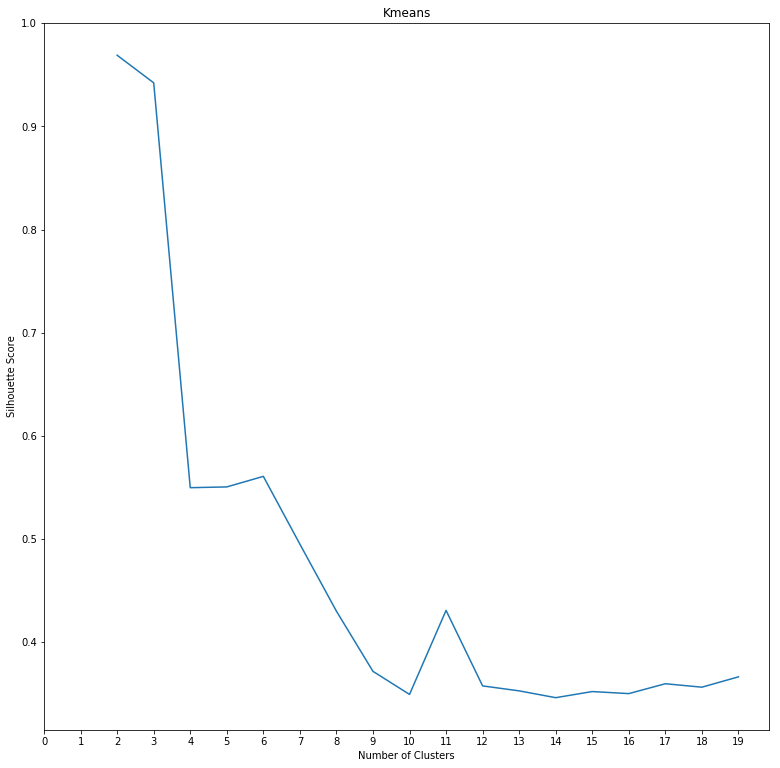

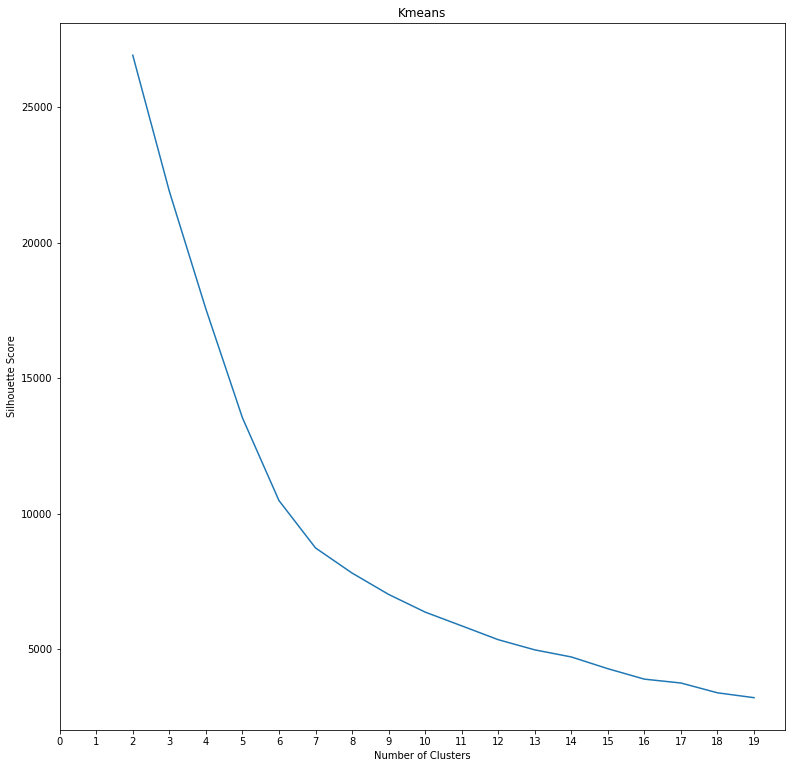

- For KMeans, 2 evaluation metrics were used. First was using Silhouette score, and the second was using the Mean Sqaured Error of distances of points from their cluster centroids.

- Silhouette score gave an elbow at 3 clusters, while KMeans gave an elbow at 7.

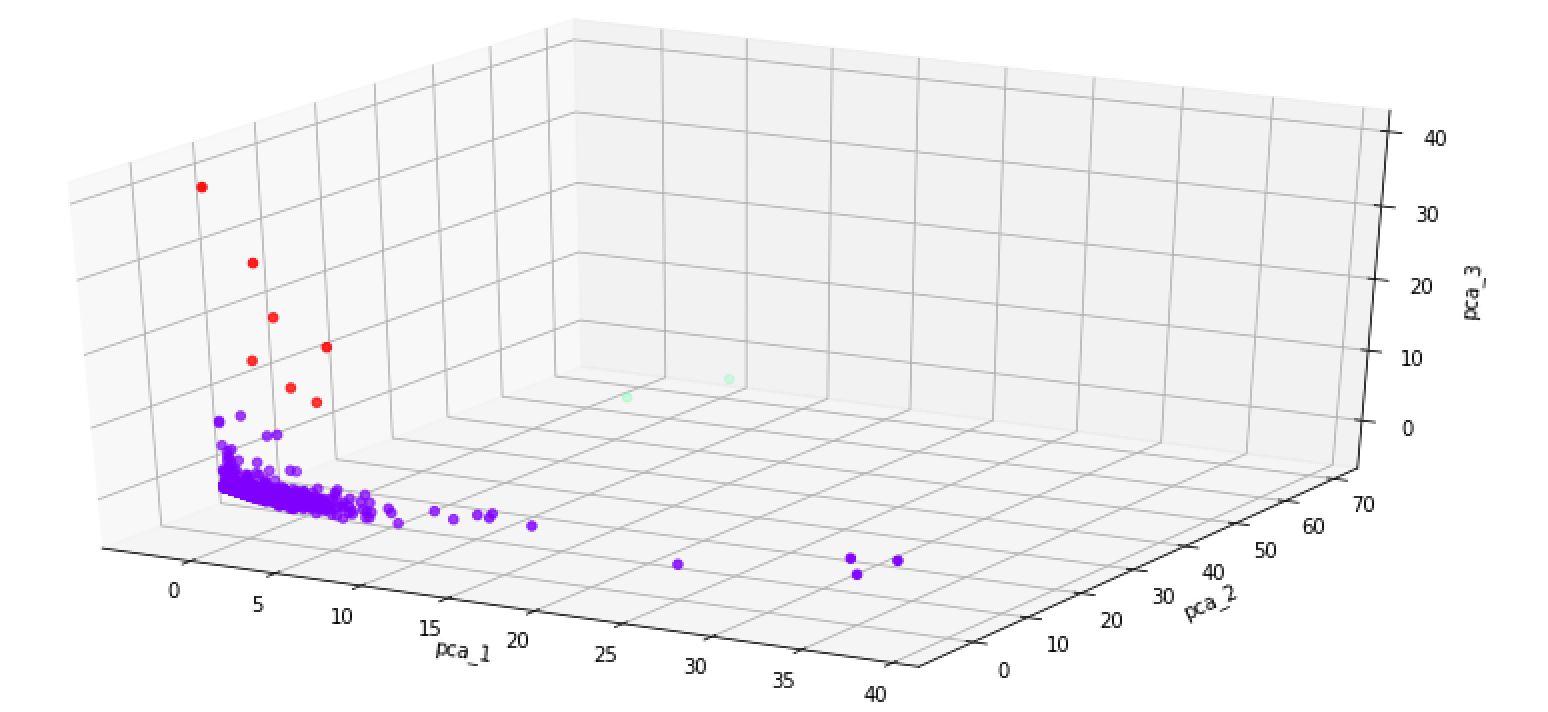

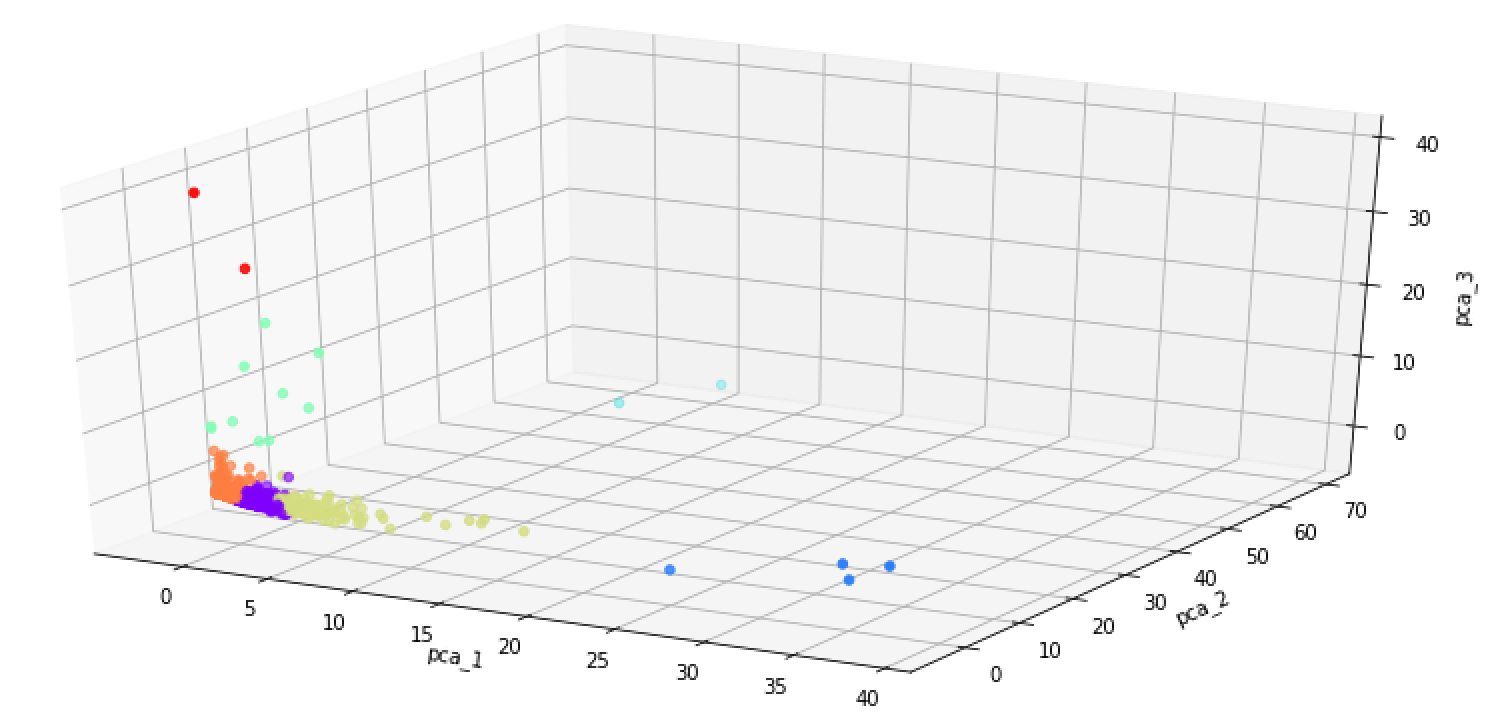

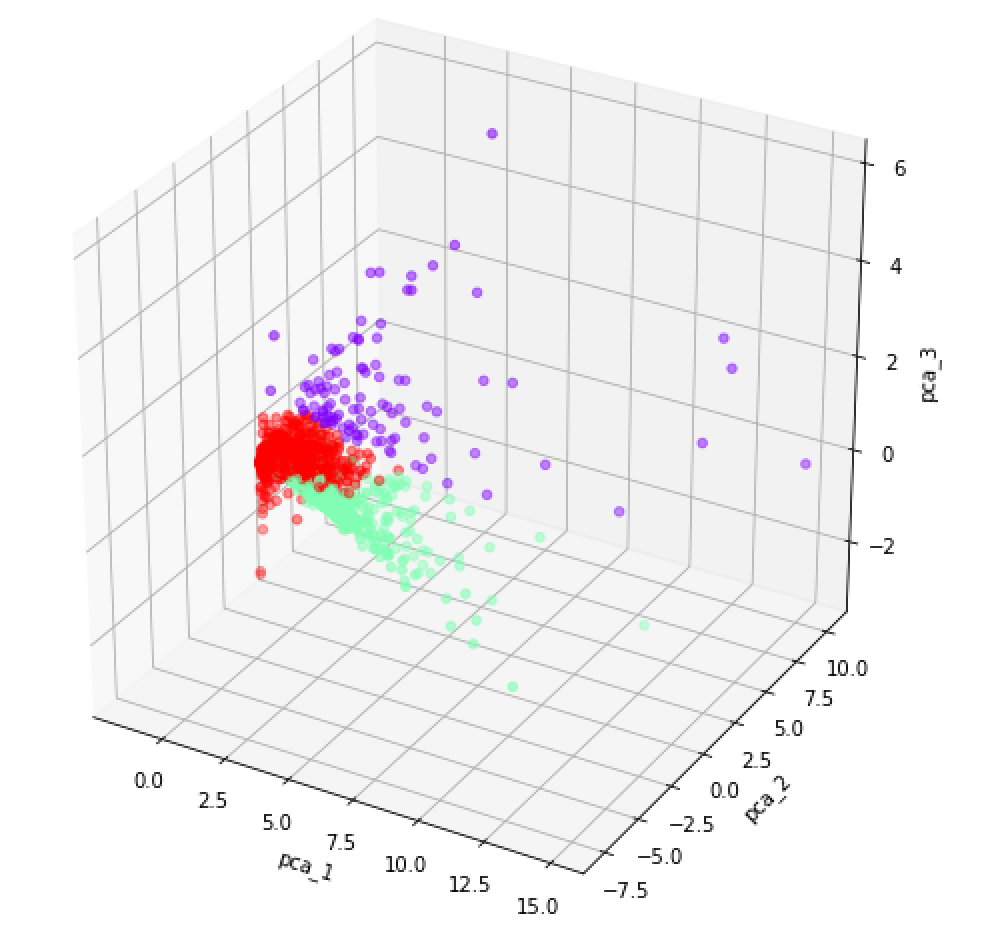

__Discussion__
After clearing out the outliers and apply PCA(3) on the dataset, 3 clusters were identified. They contained 3473, 745 and 104 datapoints respectively.

A limitation of the PCA algorithm is that it attempts to circularize the data into spherical clusters. This method might not work especially if clusters are not spehrical in nature.

The PCA method can be implemented to circularize the data and allow K means to perform better.

__Gaussian Mixture Model__

4 types of covaraince matrices:
1. Full - Each cov is independently determined
2. Tied - Same cov for all
3. Spherical - All guassigna classes only have 1 value for cov 
4. Diag - All gaussian classes only have diagonal components in their cov 

A full matrix will be used to allow maximum flexibility for clustering

<Figure size 936x936 with 0 Axes>

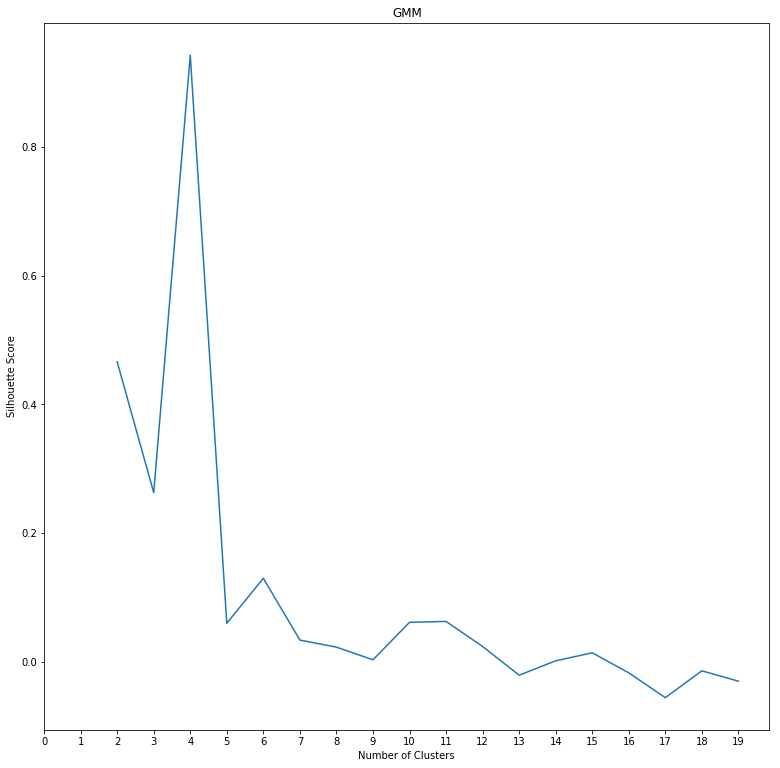

In [108]:
# Plot number of clusters as a function of silhouette coefficients
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture 

score  = []
plt.figure(figsize=(13, 13)) 
max_c = 20

for n in range(2,max_c):

    steps = [('scale', StandardScaler()),
                ('gauss', GaussianMixture(n_components=n, covariance_type='full', max_iter=1000))]
    pipe_gauss = Pipeline(steps)
    pipe_gauss.steps[1][1].fit(X)
    labels = pipe_gauss.steps[1][1].predict(X)
    score.append(metrics.silhouette_score(X, labels, metric= 'euclidean'))

plt.figure(figsize=(13, 13)) 
plt.plot(np.arange(2, max_c, step=1), score)
plt.title('GMM')  
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(np.arange(0, max_c, step=1))

plt.show()

The elbow of the silhouette score can be seen to peak at 3 to 4 clusters

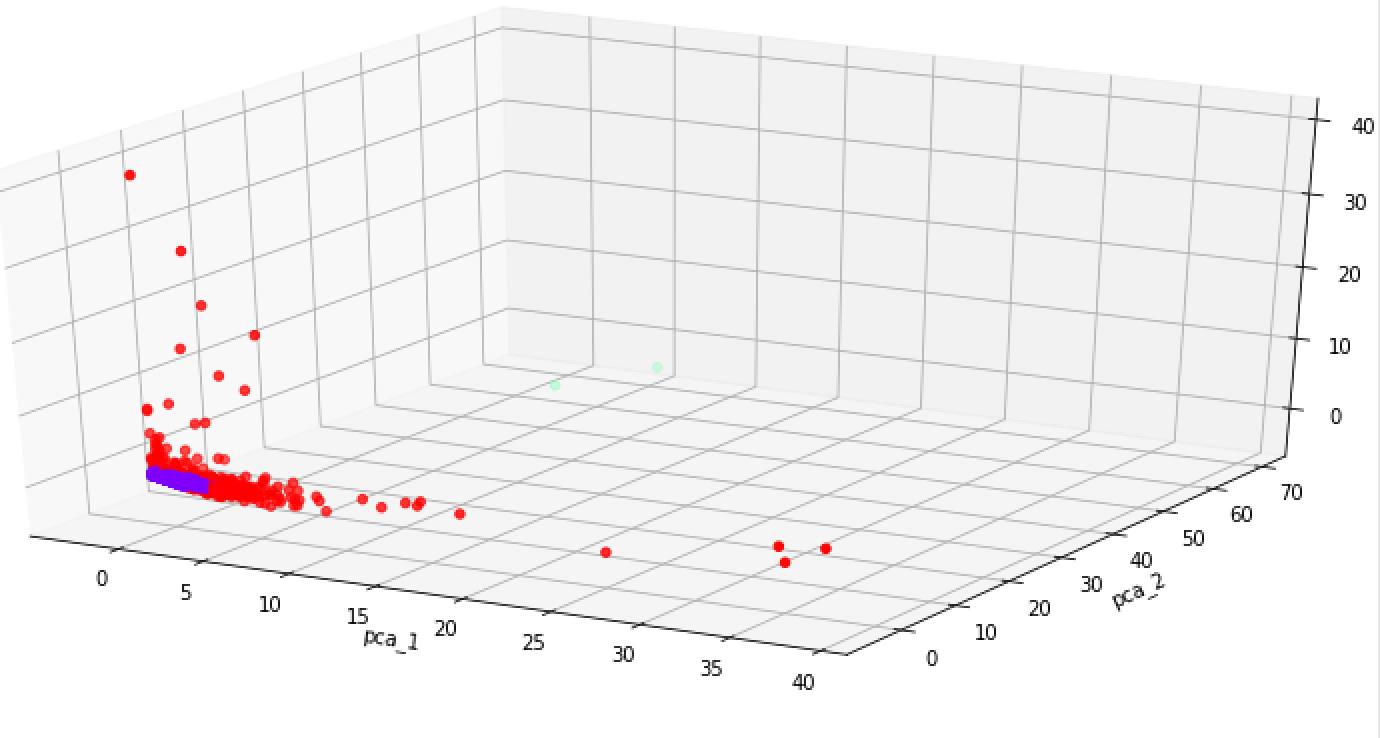

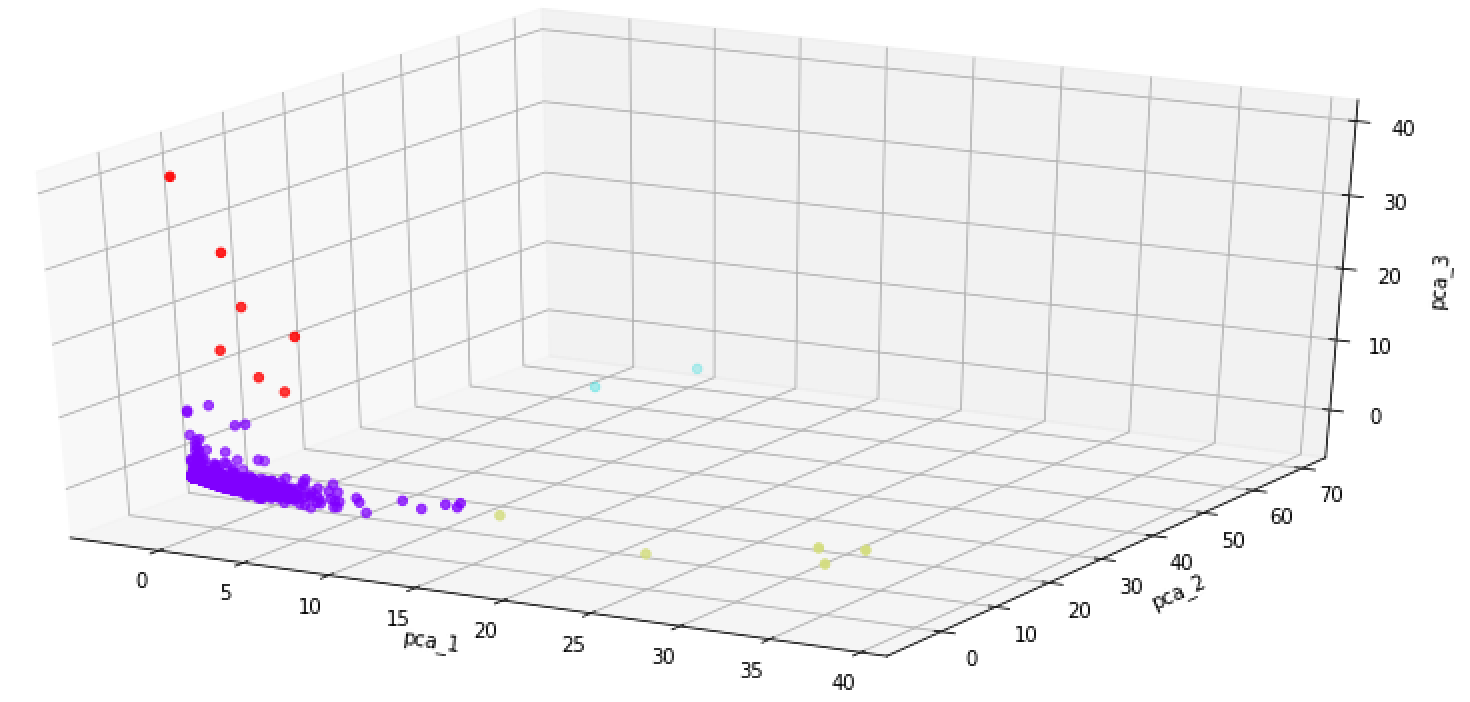

- 70% of variability in the initial data set can be explained by the 3 selected principal components. 
- As can be seen from the data, the same outlier problem can be seen.

In [159]:
steps = [('scale', StandardScaler()),
            ('gauss', GaussianMixture(n_components=6, covariance_type='full', max_iter=10000))]
pipe_gauss = Pipeline(steps)
pipe_gauss.steps[1][1].fit(X)
labels = pipe_gauss.steps[1][1].predict(X)

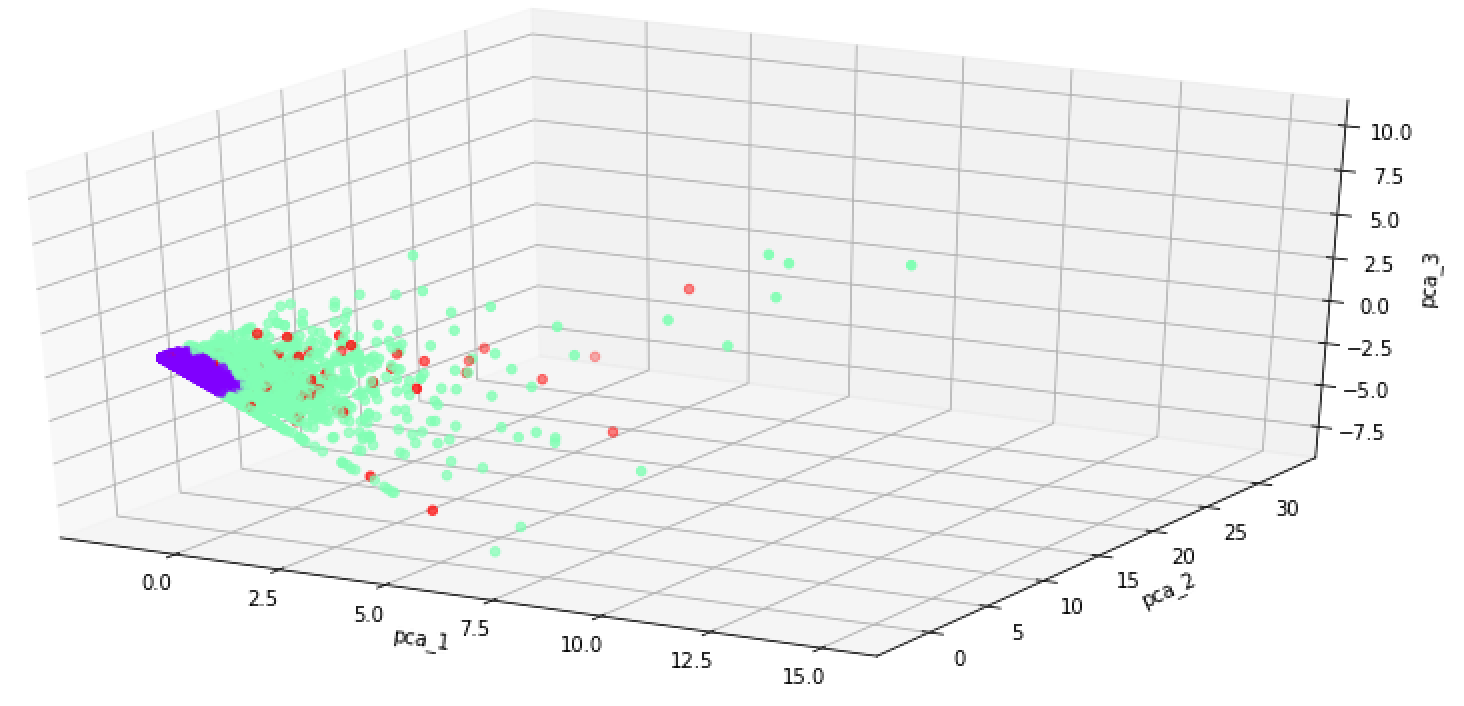

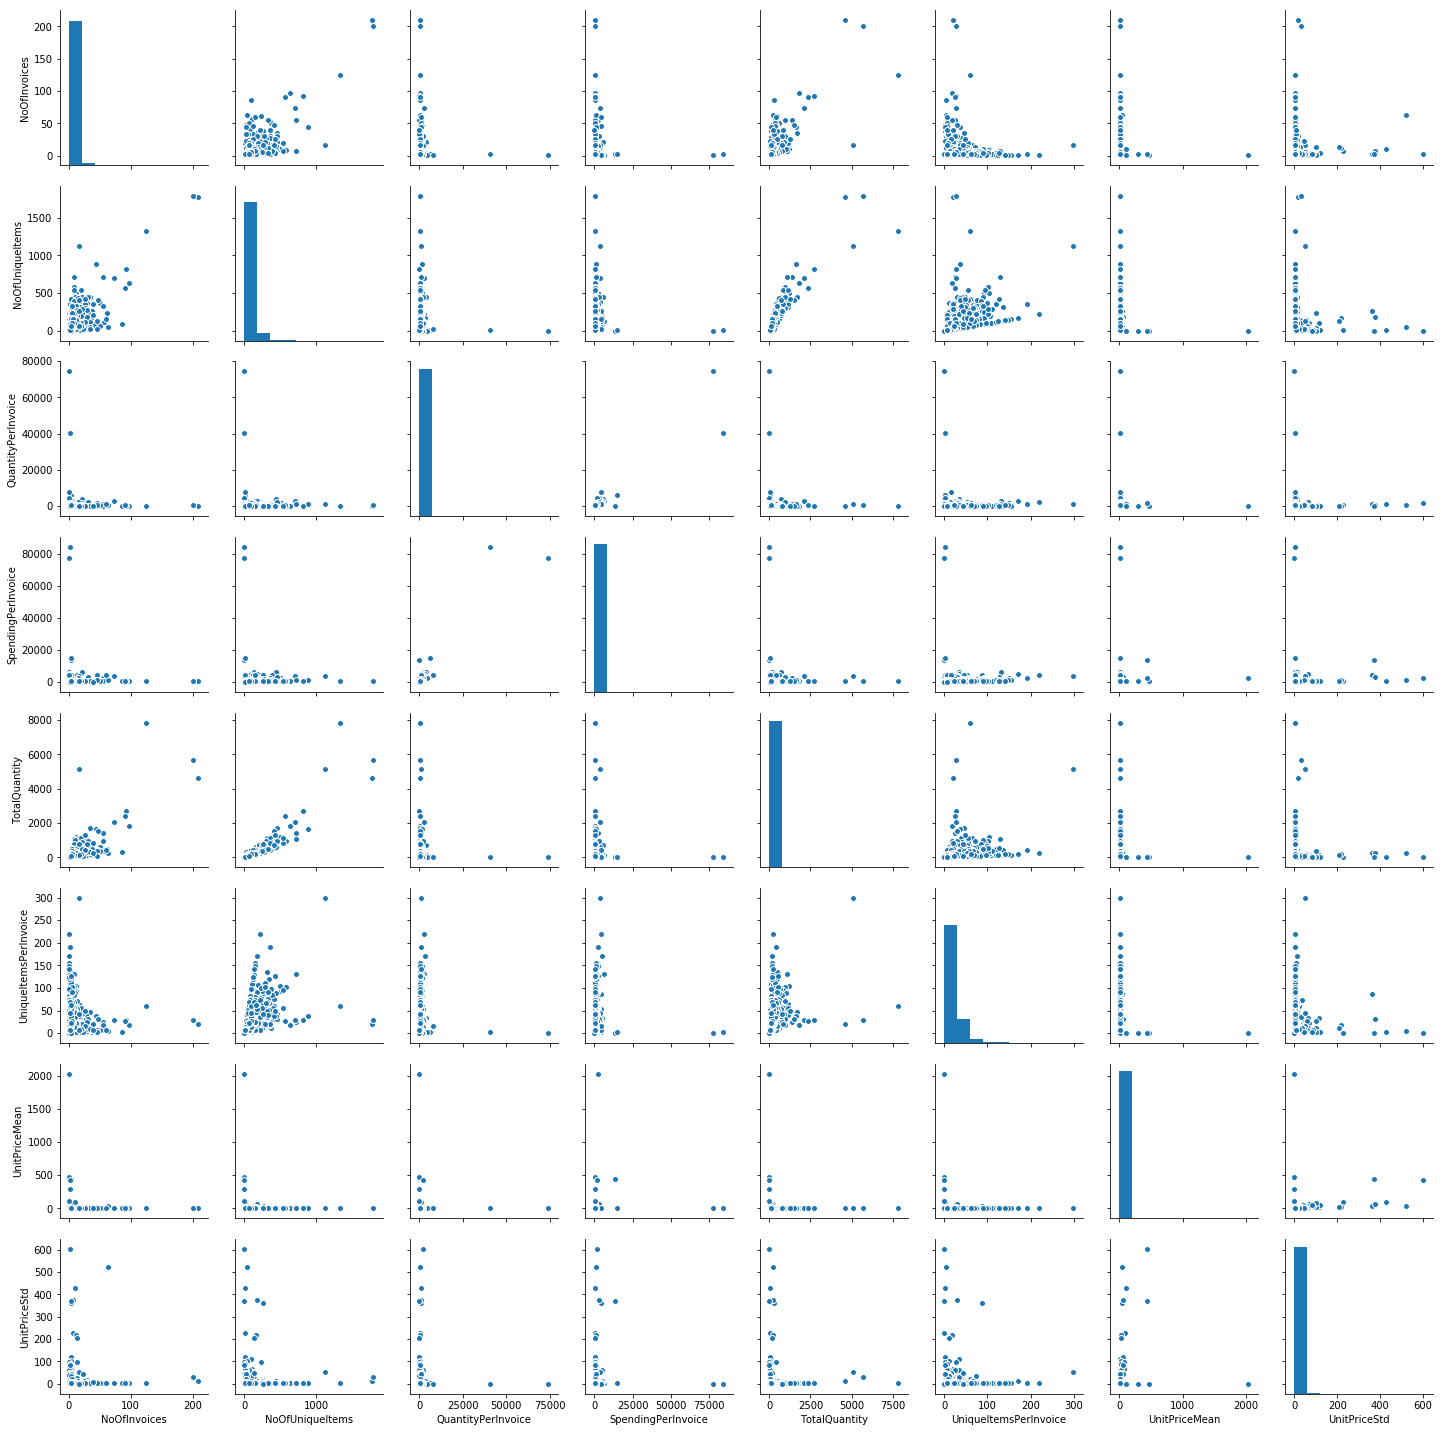

In [150]:
g = sns.pairplot(df_cust.iloc[:,1:])

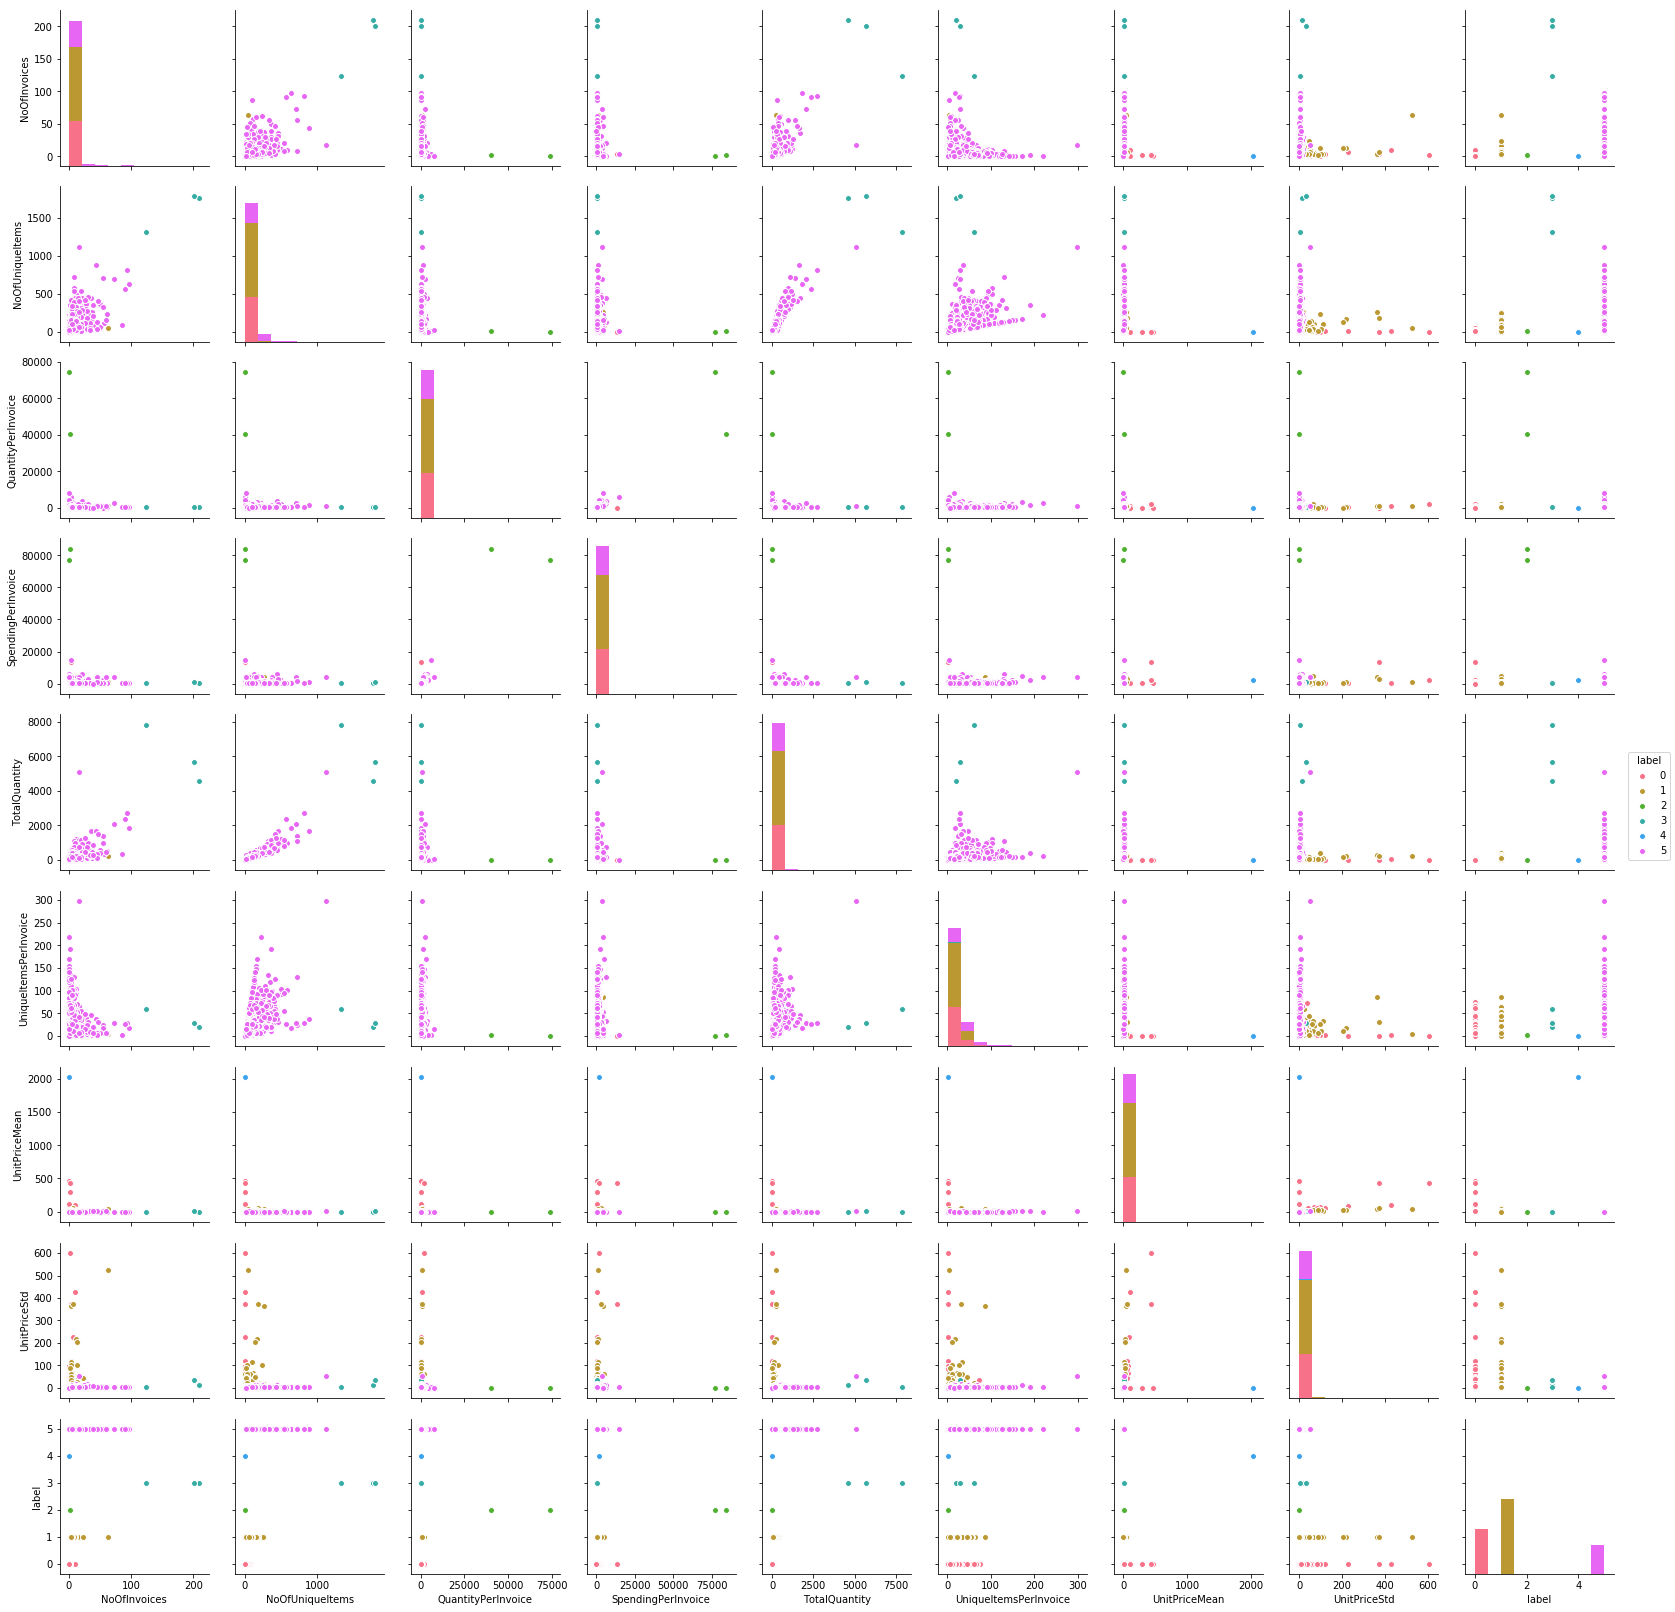

In [166]:
df_label = df_cust.iloc[:,1:]
df_label['label'] = labels

g = sns.pairplot(df_label, hue="label", palette="husl")


### Outliers 

1. Do outliers influence the results of your Hierarchical Clustering, K-means and GMM models?  
2. Do the outliers themselves form clusters? 

1) Outliers will influence K means clustering significantly since the number of clusters is fixed, and the outliers will skew a cluster or form one cluster of its own. For Hierarichal clustering, the outliers will form clusters of their own and combine with the main clusters laters on, and increase the total distsnce traversed by the algorihtm greatly. GMM on the other hand will not be greatly affected since it has soft boundaries, but the distribution of gaussian models will definitely change. 

2) Yes outliers themselves will form clusters for K means and Hierarchical clustering. For GMM, it is not as badly affected, but its possible for outliers to form a cluster as well.



### Validating clusters  

1. Use at least three techniques to validate that your chosen clusters correspond to meaningful customer segments. You may consider a combination of using visualisations and/or quantitative metrics (refer to Elements of Statistical Learning for some examples)

### Model selection

1. Explain when it is appropriate to use K-Means, GMM and Hierarchical Clustering 
2. Which model would you choose for this dataset? 

1. When no knowledge of the number of clusters is known, hierarchical clustering will be a good option to have a broad overview of the posssible cluster ditributions, and select the best number of clusters. K-Means and GMM are both models that require us to have a certain knowledge of the number of clusters. K-Means would be useful if we are certain of the distribution of clusters that we want, and we want a strict classification of datapoints into clusters(hard boundaries). GMM on th others hand allows for more flexiblity in terms of cluster shape and boundaries, and will be useful if we have a general idea of how many clusters we want, but are not so sure where the cluster boundaries should be, and want a probabilistic approach to classify the datapoints. 

2. For this model, Hierarchical clustering will be the best option since the number of clusters is uncertain. 

### Opening the black box of clustering [reference pg 503](https://web.stanford.edu/~hastie/Papers/ESLII.pdf)

1. In your own words, explain the broad idea behind building a proximity matrix to cluster data. (This should also be verbally presented during Monday's presentation). 
*Sometimes, typing values into MS Excel helps with building intuition

Hierarchical clustering takes in a proximity matrix as input, as it internally creates a distance matrix from the given data too. 

2. In your own words, how would you calculate the disimilarity between objects in a dataset? (This should also be verbally presented during Monday's presentation)

### PCA for Dimensionality Reduction 

1. Using the dataset that you have pre-processed, construct a pairplot again. How is it different from the a plot of the raw data and what is your interpretation?  
2. Apply PCA pre-processed dataset. More information on PCA here [link]
3. Create a plot of cumulative explained variance and number of components. How does this inform you about the best number of components to select? 
4. Create a plot of PC0 against PC1, coloured by the GMM's predictions on the normalised dataset with outliers removed for n_components =7
5. How would you connect the Princip

In [169]:
pca = PCA()
pca.fit(X_mod)
print(pca.explained_variance_/(np.sum(pca.explained_variance_)))


[0.61583052 0.23572174 0.04135715 0.03876612 0.02402243 0.02234389
 0.01951757 0.00244058]


In [171]:
print(df_label.columns)
print(abs(pca.components_))

Index(['NoOfInvoices', 'NoOfUniqueItems', 'QuantityPerInvoice',
       'SpendingPerInvoice', 'TotalQuantity', 'UniqueItemsPerInvoice',
       'UnitPriceMean', 'UnitPriceStd', 'label'],
      dtype='object')
[[0.49081275 0.5852806  0.02502434 0.03347439 0.57770497 0.28424078
  0.00881083 0.013756  ]
 [0.49411278 0.09752453 0.04986528 0.05911849 0.1044476  0.85364773
  0.0193681  0.01900311]
 [0.35808756 0.09948704 0.06873261 0.02739342 0.26925596 0.1547265
  0.30173415 0.81787438]
 [0.58547647 0.15012562 0.1372516  0.18667167 0.51216581 0.2854854
  0.10999344 0.47442702]
 [0.05965223 0.10237638 0.0258567  0.00196267 0.04271796 0.06720211
  0.93914907 0.31136207]
 [0.07004068 0.71033231 0.24499446 0.29675204 0.55471123 0.15309718
  0.10153272 0.03140152]
 [0.18828599 0.31667171 0.59663138 0.65626559 0.10447663 0.23875318
  0.05667646 0.08051838]
 [0.00550475 0.01289676 0.7461     0.66410662 0.00950445 0.00962191
  0.0297169  0.03216451]]
